SONATRACH Automatic Seismic Noise Detection
Starting automatic annotation...
Detecting noise using method: advanced
  Step 1: Frequency analysis...
  Step 2: Texture analysis...
  Step 3: Coherence analysis...
  Step 4: Statistical analysis...
  Step 5: Combining results...


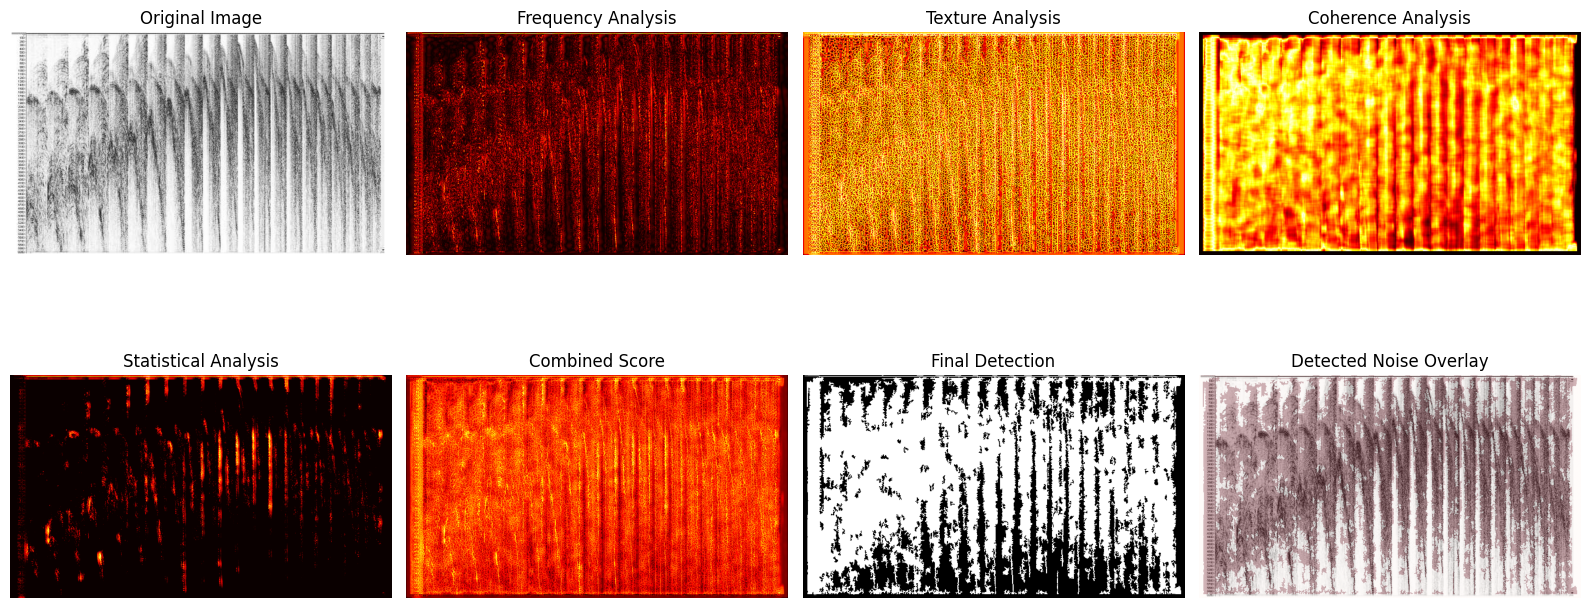

Found 15 noise regions


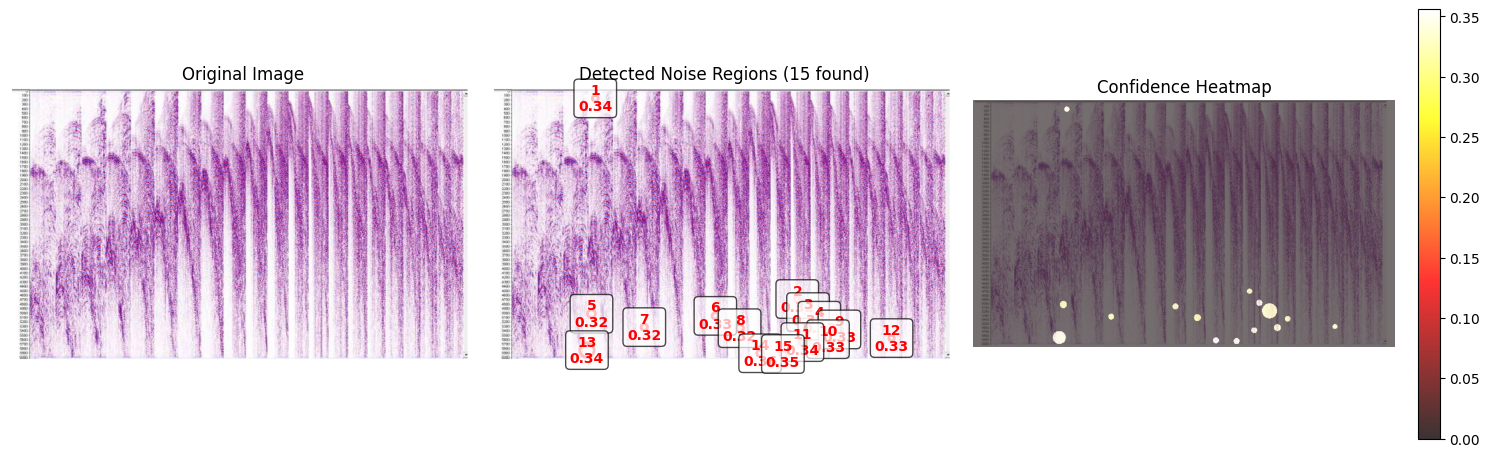

Annotations saved to: auto_annotations_20250929_140943.json
=== Automatic Seismic Noise Detection Demo ===
Starting automatic annotation...
Detecting noise using method: advanced
  Step 1: Frequency analysis...
  Step 2: Texture analysis...
  Step 3: Coherence analysis...
  Step 4: Statistical analysis...
  Step 5: Combining results...


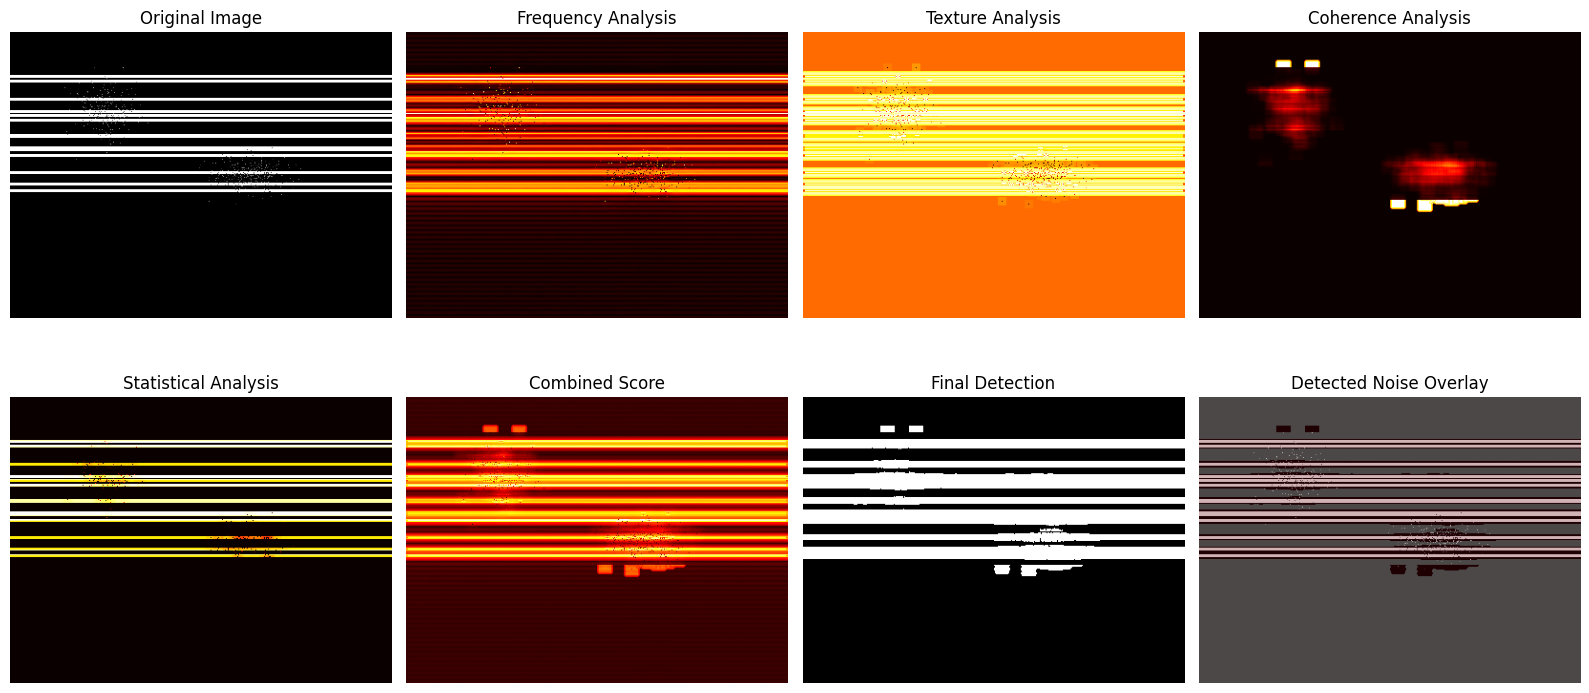

Found 9 noise regions


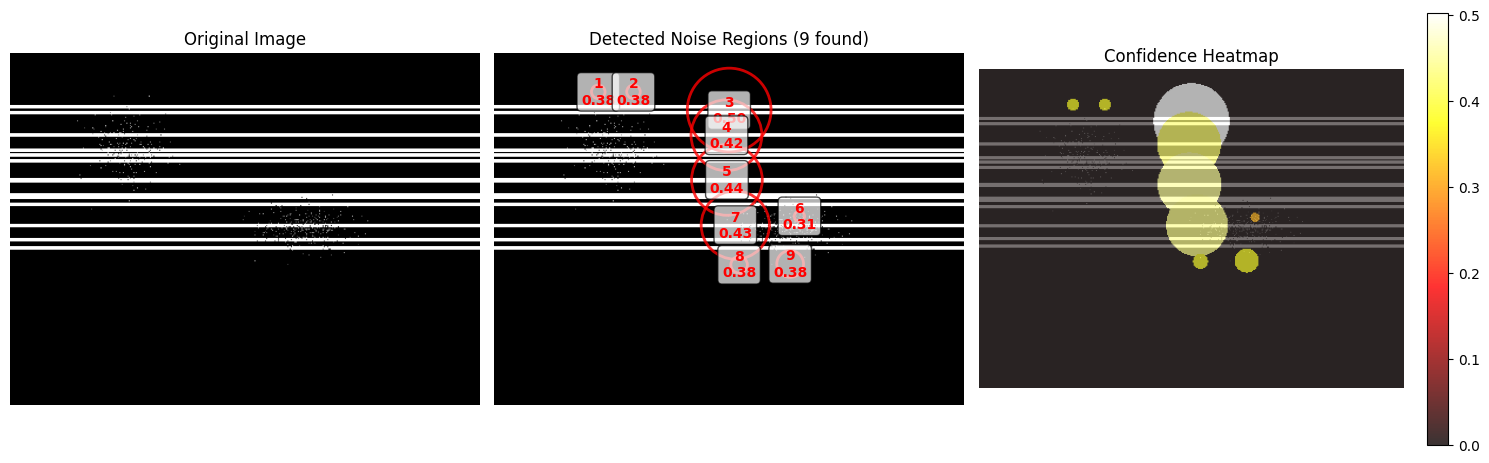

Annotations saved to: auto_annotations_20250929_140947.json

Demo completed! Found 9 noise regions


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import json
import os
from datetime import datetime
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from skimage import feature, filters, measure, segmentation, morphology
from skimage.filters import threshold_otsu, gaussian
from scipy import ndimage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

class AutomaticSeismicAnnotator:
    def __init__(self):
        self.noise_threshold = 0.3
        self.min_noise_size = 50
        self.max_noise_size = 5000
        self.coherence_threshold = 0.8
        
    def detect_noise_regions(self, image, method='advanced', show_process=True):
        """
        Automatically detect noise regions in seismic image
        
        Methods:
        - 'advanced': Uses multiple techniques combined
        - 'frequency': Frequency domain analysis
        - 'texture': Texture-based detection
        - 'coherence': Coherence analysis
        """
        
        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
        
        print(f"Detecting noise using method: {method}")
        
        if method == 'advanced':
            noise_regions = self._advanced_noise_detection(gray, show_process)
        elif method == 'frequency':
            noise_regions = self._frequency_noise_detection(gray, show_process)
        elif method == 'texture':
            noise_regions = self._texture_noise_detection(gray, show_process)
        elif method == 'coherence':
            noise_regions = self._coherence_noise_detection(gray, show_process)
        else:
            print(f"Unknown method: {method}, using 'advanced'")
            noise_regions = self._advanced_noise_detection(gray, show_process)
        
        return noise_regions
    
    def _advanced_noise_detection(self, gray, show_process=True):
        """Advanced multi-method noise detection"""
        
        # Normalize image
        gray_norm = cv2.normalize(gray.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        
        # Step 1: Frequency domain analysis
        print("  Step 1: Frequency analysis...")
        freq_noise = self._detect_frequency_anomalies(gray_norm)
        
        # Step 2: Texture analysis  
        print("  Step 2: Texture analysis...")
        texture_noise = self._detect_texture_anomalies(gray_norm)
        
        # Step 3: Coherence analysis
        print("  Step 3: Coherence analysis...")
        coherence_noise = self._detect_coherence_anomalies(gray_norm)
        
        # Step 4: Statistical outlier detection
        print("  Step 4: Statistical analysis...")
        statistical_noise = self._detect_statistical_anomalies(gray_norm)
        
        # Combine all methods
        print("  Step 5: Combining results...")
        combined_noise = (freq_noise + texture_noise + coherence_noise + statistical_noise) / 4.0
        
        # Threshold and clean up
        noise_binary = combined_noise > self.noise_threshold
        noise_binary = morphology.remove_small_objects(noise_binary, min_size=self.min_noise_size)
        noise_binary = morphology.remove_small_holes(noise_binary, area_threshold=self.min_noise_size//2)
        
        if show_process:
            self._show_detection_process(gray_norm, freq_noise, texture_noise, 
                                       coherence_noise, statistical_noise, combined_noise, noise_binary)
        
        # Extract noise regions
        labeled_regions = measure.label(noise_binary)
        regions = measure.regionprops(labeled_regions)
        
        noise_regions = []
        for region in regions:
            if self.min_noise_size < region.area < self.max_noise_size:
                # Create circular approximation
                center = region.centroid[::-1]  # (x, y)
                radius = np.sqrt(region.area / np.pi)
                
                noise_regions.append({
                    'type': 'circle',
                    'center': center,
                    'radius': radius,
                    'area': region.area,
                    'confidence': np.mean(combined_noise[region.coords[:, 0], region.coords[:, 1]]),
                    'bbox': region.bbox
                })
        
        return noise_regions
    
    def _detect_frequency_anomalies(self, image):
        """Detect noise using frequency domain analysis"""
        # Apply FFT
        f_transform = np.fft.fft2(image)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.log(np.abs(f_shift) + 1)
        
        # High-pass filter to emphasize noise
        rows, cols = image.shape
        crow, ccol = rows//2, cols//2
        
        # Create mask for high frequencies
        mask = np.zeros((rows, cols), dtype=np.float32)
        r = 30  # radius for low frequencies to remove
        y, x = np.ogrid[:rows, :cols]
        mask_area = (x - ccol)**2 + (y - crow)**2 <= r*r
        mask[mask_area] = 1
        mask = 1 - mask  # Invert to keep high frequencies
        
        # Apply mask and inverse FFT
        f_shift_filtered = f_shift * mask
        f_ishift = np.fft.ifftshift(f_shift_filtered)
        img_filtered = np.fft.ifft2(f_ishift)
        noise_map = np.abs(img_filtered)
        
        # Normalize
        noise_map = cv2.normalize(noise_map, None, 0, 1, cv2.NORM_MINMAX)
        
        return noise_map
    
    def _detect_texture_anomalies(self, image):
        """Detect noise using texture analysis"""
        # Local Binary Pattern
        lbp = feature.local_binary_pattern(image, P=8, R=2, method='uniform')
        
        # Calculate local standard deviation
        kernel = np.ones((9, 9))
        local_mean = ndimage.uniform_filter(image, size=9)
        local_var = ndimage.uniform_filter(image**2, size=9) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))
        
        # Combine LBP variance and local std
        lbp_norm = cv2.normalize(lbp, None, 0, 1, cv2.NORM_MINMAX)
        std_norm = cv2.normalize(local_std, None, 0, 1, cv2.NORM_MINMAX)
        
        texture_noise = (lbp_norm * 0.6 + std_norm * 0.4)
        
        return texture_noise
    
    def _detect_coherence_anomalies(self, image):
        """Detect noise using coherence analysis"""
        # Calculate gradients
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        # Gradient magnitude and direction
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        grad_dir = np.arctan2(grad_y, grad_x)
        
        # Local coherence measure
        coherence_map = np.zeros_like(image)
        window_size = 15
        
        for i in range(window_size//2, image.shape[0] - window_size//2):
            for j in range(window_size//2, image.shape[1] - window_size//2):
                window_dir = grad_dir[i-window_size//2:i+window_size//2+1, 
                                    j-window_size//2:j+window_size//2+1]
                window_mag = grad_mag[i-window_size//2:i+window_size//2+1, 
                                    j-window_size//2:j+window_size//2+1]
                
                # Calculate directional coherence
                if np.sum(window_mag) > 0:
                    cos_sum = np.sum(window_mag * np.cos(2 * window_dir))
                    sin_sum = np.sum(window_mag * np.sin(2 * window_dir))
                    coherence = np.sqrt(cos_sum**2 + sin_sum**2) / np.sum(window_mag)
                    coherence_map[i, j] = 1 - coherence  # Invert: high value = low coherence = noise
        
        return coherence_map
    
    def _detect_statistical_anomalies(self, image):
        """Detect noise using statistical analysis"""
        # Local statistics
        kernel_size = 11
        local_mean = ndimage.uniform_filter(image, size=kernel_size)
        local_var = ndimage.uniform_filter(image**2, size=kernel_size) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))
        
        # Z-score based anomaly detection
        global_mean = np.mean(image)
        global_std = np.std(image)
        z_scores = np.abs(image - global_mean) / (global_std + 1e-8)
        
        # Combine local variation and z-scores
        local_std_norm = cv2.normalize(local_std, None, 0, 1, cv2.NORM_MINMAX)
        z_scores_norm = cv2.normalize(z_scores, None, 0, 1, cv2.NORM_MINMAX)
        
        statistical_noise = (local_std_norm * 0.7 + z_scores_norm * 0.3)
        
        # Apply threshold
        threshold = np.percentile(statistical_noise, 85)
        statistical_noise = np.maximum(0, statistical_noise - threshold) / (1 - threshold + 1e-8)
        
        return statistical_noise
    
    def _show_detection_process(self, original, freq, texture, coherence, statistical, combined, binary):
        """Show the step-by-step detection process"""
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        axes[0, 0].imshow(original, cmap='gray')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(freq, cmap='hot')
        axes[0, 1].set_title('Frequency Analysis')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(texture, cmap='hot')
        axes[0, 2].set_title('Texture Analysis')
        axes[0, 2].axis('off')
        
        axes[0, 3].imshow(coherence, cmap='hot')
        axes[0, 3].set_title('Coherence Analysis')
        axes[0, 3].axis('off')
        
        axes[1, 0].imshow(statistical, cmap='hot')
        axes[1, 0].set_title('Statistical Analysis')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(combined, cmap='hot')
        axes[1, 1].set_title('Combined Score')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(binary, cmap='gray')
        axes[1, 2].set_title('Final Detection')
        axes[1, 2].axis('off')
        
        # Show original with detected regions overlaid
        axes[1, 3].imshow(original, cmap='gray')
        axes[1, 3].imshow(binary, cmap='Reds', alpha=0.3)
        axes[1, 3].set_title('Detected Noise Overlay')
        axes[1, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def annotate_image(self, image, method='advanced', show_results=True, save_annotations=True, output_path=None):
        """
        Automatically annotate noise in seismic image
        """
        print(f"Starting automatic annotation...")
        
        # Detect noise regions
        noise_regions = self.detect_noise_regions(image, method=method, show_process=show_results)
        
        print(f"Found {len(noise_regions)} noise regions")
        
        if show_results:
            self._visualize_annotations(image, noise_regions)
        
        # Save annotations 
        if save_annotations:
            annotation_data = {
                'method': method,
                'total_regions': len(noise_regions),
                'detection_parameters': {
                    'noise_threshold': self.noise_threshold,
                    'min_noise_size': self.min_noise_size,
                    'max_noise_size': self.max_noise_size
                },
                'regions': []
            }
            
            for i, region in enumerate(noise_regions):
                annotation_data['regions'].append({
                    'id': i + 1,
                    'type': region['type'],
                    'center': region['center'],
                    'radius': region['radius'],
                    'area': region['area'],
                    'confidence': float(region['confidence']),
                    'bbox': region['bbox']
                })
            
            # Save to file
            if output_path is None:
                output_path = f"auto_annotations_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            
            with open(output_path, 'w') as f:
                json.dump(annotation_data, f, indent=2)
            
            print(f"Annotations saved to: {output_path}")
        
        return noise_regions
    
    def _visualize_annotations(self, image, noise_regions):
        """Visualize the automatically detected annotations"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        if len(image.shape) == 3:
            axes[0].imshow(image)
        else:
            axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Image with circles
        if len(image.shape) == 3:
            axes[1].imshow(image)
        else:
            axes[1].imshow(image, cmap='gray')
        
        for i, region in enumerate(noise_regions):
            circle = Circle(region['center'], region['radius'], 
                          fill=False, edgecolor='red', linewidth=2, alpha=0.8)
            axes[1].add_patch(circle)
            # Add confidence text
            axes[1].text(region['center'][0], region['center'][1], 
                        f"{i+1}\n{region['confidence']:.2f}", 
                        fontsize=10, color='red', weight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        axes[1].set_title(f'Detected Noise Regions ({len(noise_regions)} found)')
        axes[1].axis('off')
        
        # Confidence heatmap
        confidence_map = np.zeros(image.shape[:2])
        for region in noise_regions:
            # Create mask for this region
            y, x = np.ogrid[:image.shape[0], :image.shape[1]]
            mask = (x - region['center'][0])**2 + (y - region['center'][1])**2 <= region['radius']**2
            confidence_map[mask] = region['confidence']
        
        im = axes[2].imshow(confidence_map, cmap='hot', alpha=0.8)
        if len(image.shape) == 3:
            axes[2].imshow(image, alpha=0.3)
        else:
            axes[2].imshow(image, cmap='gray', alpha=0.3)
        axes[2].set_title('Confidence Heatmap')
        axes[2].axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[2], fraction=0.046)
        
        plt.tight_layout()
        plt.show()
    
    def batch_annotate(self, image_folder, output_folder=None, method='advanced'):
        """
        Automatically annotate all images in a folder
        """
        if output_folder is None:
            output_folder = os.path.join(image_folder, 'auto_annotations')
        
        os.makedirs(output_folder, exist_ok=True)
        
        image_extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp']
        results = []
        
        for filename in sorted(os.listdir(image_folder)):
            if any(filename.lower().endswith(ext) for ext in image_extensions):
                image_path = os.path.join(image_folder, filename)
                print(f"\nProcessing: {filename}")
                
                # Load image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"  Could not load image: {filename}")
                    continue
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Annotate
                base_name = os.path.splitext(filename)[0]
                output_path = os.path.join(output_folder, f"{base_name}_annotations.json")
                
                noise_regions = self.annotate_image(
                    image, method=method, show_results=False, 
                    save_annotations=True, output_path=output_path
                )
                
                # Save annotated image
                fig, ax = plt.subplots(1, 1, figsize=(10, 8))
                ax.imshow(image)
                
                for i, region in enumerate(noise_regions):
                    circle = Circle(region['center'], region['radius'], 
                                  fill=False, edgecolor='red', linewidth=2)
                    ax.add_patch(circle)
                    ax.text(region['center'][0], region['center'][1], str(i+1),
                           fontsize=12, color='red', weight='bold', ha='center', va='center')
                
                ax.set_title(f'{filename} - {len(noise_regions)} noise regions detected')
                ax.axis('off')
                
                annotated_image_path = os.path.join(output_folder, f"{base_name}_annotated.png")
                plt.savefig(annotated_image_path, dpi=150, bbox_inches='tight')
                plt.close()
                
                results.append({
                    'filename': filename,
                    'noise_regions': len(noise_regions),
                    'average_confidence': np.mean([r['confidence'] for r in noise_regions]) if noise_regions else 0,
                    'annotation_file': output_path,
                    'annotated_image': annotated_image_path
                })
                
                print(f"  Found {len(noise_regions)} noise regions")
        
        # Save summary
        summary_df = pd.DataFrame(results)
        summary_path = os.path.join(output_folder, 'annotation_summary.csv')
        summary_df.to_csv(summary_path, index=False)
        
        print(f"\nBatch annotation complete!")
        print(f"Processed {len(results)} images")
        print(f"Results saved to: {output_folder}")
        print(f"Summary saved to: {summary_path}")
        
        return results

# Helper functions 
def annotate_single_image(image_path, method='advanced', show_results=True):
    """Quickly annotate a single image"""
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    annotator = AutomaticSeismicAnnotator()
    noise_regions = annotator.annotate_image(image, method=method, show_results=show_results)
    
    return noise_regions

def demo_automatic_annotation():
    """Demonstrate automatic annotation with synthetic data"""
    print("=== Automatic Seismic Noise Detection Demo ===")
    
    # Create synthetic seismic image with noise
    image = create_synthetic_seismic_with_noise()
    
    # Initialize annotator
    annotator = AutomaticSeismicAnnotator()
    
    # Detect noise automatically
    noise_regions = annotator.annotate_image(image, method='advanced', show_results=True)
    
    print(f"\nDemo completed! Found {len(noise_regions)} noise regions")
    return annotator, noise_regions

def create_synthetic_seismic_with_noise(size=(300, 400)):
    """Create synthetic seismic data with artificial noise for testing"""
    image = np.zeros(size, dtype=np.uint8)
    
    # Add seismic reflections
    for i in range(0, size[1], 25):
        y = int(50 + i * 0.3 + 20 * np.sin(i * 0.1))
        if 0 <= y < size[0] - 5:
            image[y:y+3, :] = 200
    
    # Add noise regions
    # Noise region 1
    center1 = (100, 80)
    for _ in range(200):
        x = int(center1[0] + np.random.normal(0, 15))
        y = int(center1[1] + np.random.normal(0, 15))
        if 0 <= x < size[1] and 0 <= y < size[0]:
            image[y, x] = np.random.randint(50, 150)
    
    # Noise region 2
    center2 = (250, 150)
    for _ in range(300):
        x = int(center2[0] + np.random.normal(0, 20))
        y = int(center2[1] + np.random.normal(0, 10))
        if 0 <= x < size[1] and 0 <= y < size[0]:
            image[y, x] = np.random.randint(30, 120)
    
    return image


if __name__ == "__main__":
    print("SONATRACH Automatic Seismic Noise Detection")
    print("===========================================")
    
annotator = AutomaticSeismicAnnotator()

#single image with full control
image = cv2.imread('fig17.png')
noise_regions = annotator.annotate_image(image, method='advanced', show_results=True)


annotator, results = demo_automatic_annotation()